In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Question 1 - Edge detection

## Section B

In [ ]:
def zero_crossing(LoG, a, b):
    """
    This function gets as input the LoG and calculates the zero crossings.
    The output is a binary matrix with 1 in all the zero crossing pixels
    and 0 otherwise.
    """

    return np.zeros_like(LoG) # Replace with zero crossing code

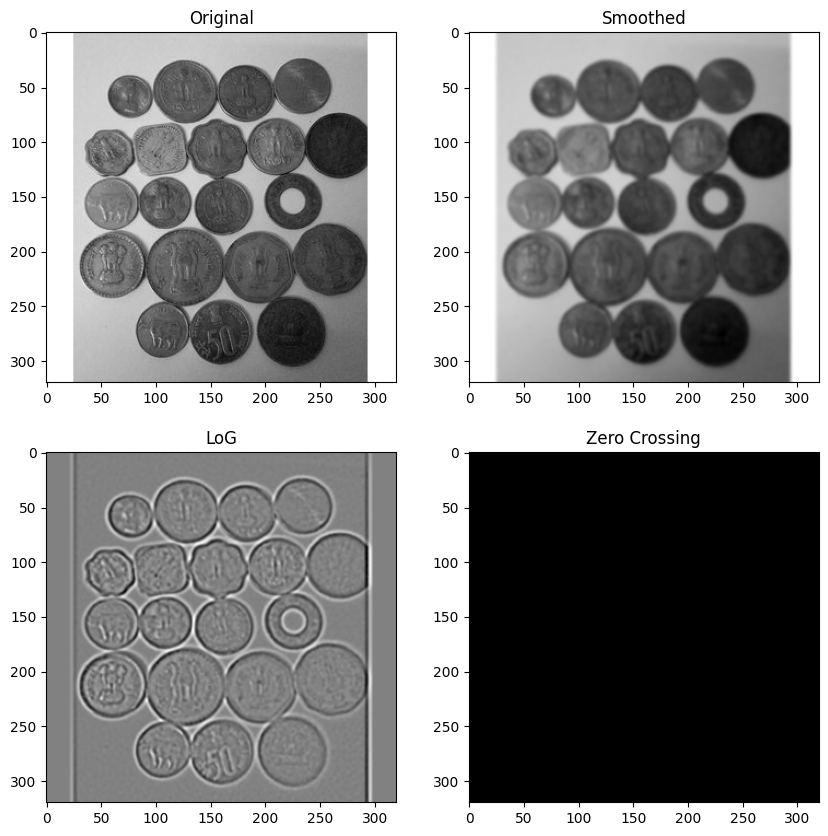

In [ ]:
# Reads the original image in grayscale, and sets the image range to be 0-1 (instead of 0-255)
coins = cv2.imread('coins_edges.jpg', cv2.IMREAD_GRAYSCALE).astype(float) / 255 #'coins': The original image in grayscale.

## Implementation of LoG as shown in tutorial #6
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0],
])
# 'smoothed': The smoothed image (i.e., the image after applying the Gaussian smoothing).
smoothed = cv2.GaussianBlur(coins, (7, 7) ,0) # You may change the 'ksize' parameter (7,7) and the sigma parameter 0.
LoG = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(float) #'LoG': The image after applying LoG.

# 'zc': The image of the detected edges after applying zero-crossing.
zc = zero_crossing(LoG,
                   a = 0.1,
                   b = -0.1) # You may change the parameters a, b to get the best result


# Showing the 4 plots requested in this section
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img ,title in zip(axes.flatten(),
                          [coins, smoothed, LoG, zc],
                          ["Original", "Smoothed", "LoG", "Zero Crossing"]):
    ax.imshow(img,
              cmap='gray')
    ax.set_title(title)


## Section C

In [ ]:
# coins' image with added Gaussian noise
noisy_coins = coins + np.random.standard_normal(coins.shape) * 0.05

# OpenCV expects image with value range of 0 - 255
# Therefore, for cv2 functions (such as cv2.Canny) use the following variable instead of 'noisy_coins'
noisy_coins_uint8 = (noisy_coins * 255).astype(np.uint8)

#=============
# Find edges in the noisy image by using
# cv2.Canny and your method from section A. Plot the results side by side.

# Question 3 - Hough Transform

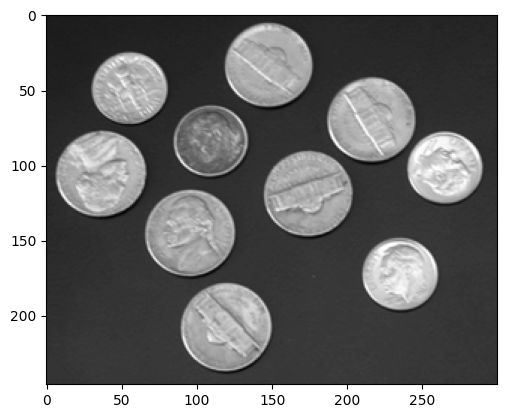

In [ ]:
# Step 0: Read the image in grayscale
img = cv2.imread('coins_Hough.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

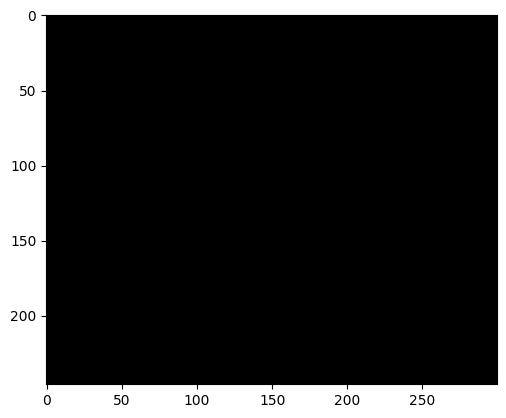

In [ ]:
def edgeDetector(image):
  '''
  This function should get as input the grayscale 'image' and any additional
  parameters you need, and return 'edge_map': a binary image (same shape as 'image')
  with a value of 1 in each detected edge pixel and a value of zero otherwise.
  '''
  edge_map = np.zeros_like(image) # Replace with edge detection code
  return edge_map

# Step 1: Produce an edge map from the image using an edge detector
edges = edgeDetector(img)
plt.imshow(edges, cmap='gray')

In [ ]:
def HoughCircles(edge_map):
  '''
  This function should get as input binary edge map and any additional
  parameters needed to compute the Hough space and to find the local maximums.
  It should first compute the Hough space, i.e. the votes of each edge pixel
  for all the relevant circles passing by it. Then, it should detect the local
  maximum points which are equivalent to detecting the circles in the image.
  The algorithm should return the parameters representing the detected circles.
  Note: you must explain any additional input and\or output parameters to this algorithm
  in your attached pdf file.
  '''
  #======= Replace with relevant code
  detected_circles = [x for x in range(10)]
  #========
  return detected_circles

# Step 2: Detect circles in the image using Hough transform
detected_circles = HoughCircles(edges)

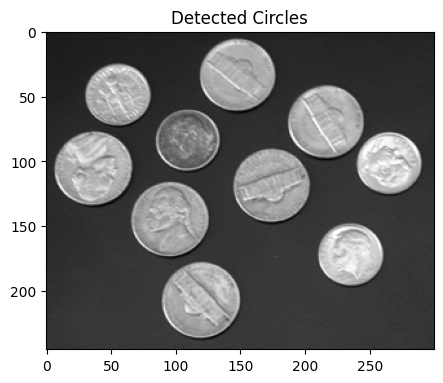

In [ ]:
def plotCircles(image):
  '''
  This function should plot the detected circles.
  It should draw the circles on top of the original grayscale image.
  You must add to this function parameters representing the detected circles
  that should be drawn.
  '''
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(image, cmap="gray")
  ax.title.set_text("Detected Circles")

  #=======
  # add your code to draw and plot circles
  #=======


# Step 3: Plot the detected circles on top of the original image
plotCircles(img)